In [1]:
!pip install spektral -q

import numpy as np
import matplotlib.pyplot as plt
import sys, gc, os
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input
from spektral.data import DisjointLoader
from spektral.transforms.normalize_adj import NormalizeAdj

# to import data from drive
from google.colab import drive
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/GraphoVerse/')

from graph import VIPERSGraph, VIPERSGraphPhoto, VIPERSGraphHav, VIPERSOriginal, NearestNeigh
from models import NezNet, DenseNet
from utils import z_metrics, best_scores, find_thres, cat_max_id, VIP_norm 
from utils import plot_results, plot_roc, plot_roc_dz, plot_roc_nn, plot_results_dz, plot_results_nn, plot_Dz_gradients, plot_pair_gradients, plot_neigh_gradients, PDFs, plot_results_single, plot_results_compare, ccplot
from train import train_model, test_model

W1 = '/content/drive/MyDrive/GraphoVerse/W1_PHOT-SPEC_MATCH_PDR.txt'  # training and validation
W4 = '/content/drive/MyDrive/GraphoVerse/W4_PHOT-SPEC_MATCH_PDR.txt'  # testing

## to re-upload stuff
#import importlib
#import graph
#importlib.reload(graph)
#from graph import *

     |████████████████████████████████| 140 kB 4.3 MB/s 
Mounted at /content/drive


In [ ]:
# to re-upload stuff
import importlib
import utils
importlib.reload(utils)
from utils import *

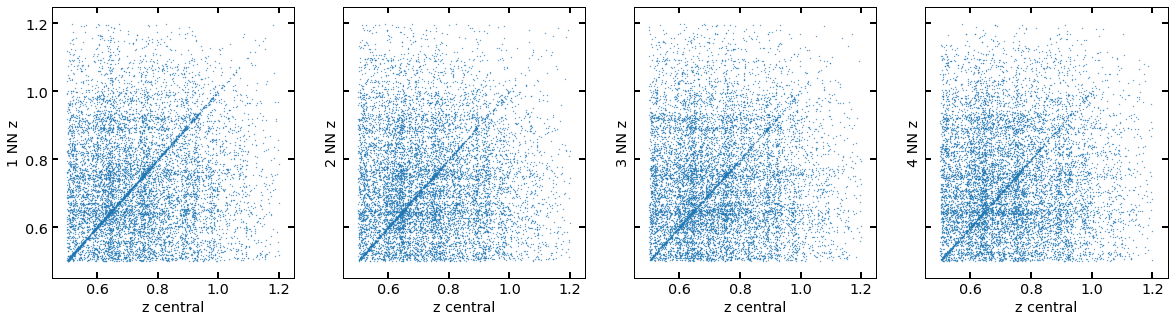

In [ ]:
# redshift range
z_min=0.5
z_max=1.2

# create graph dataset
nids = cat_max_id(W1,z_min,z_max)
norms = VIP_norm(z_min,z_max) # norm [0,1]

n_nbrs = 5

ids = np.random.choice(np.arange(nids), size=10000, replace=False)
data_neigh = NearestNeigh( ids, *norms, n_nbrs=n_nbrs, transforms=NormalizeAdj(), z_min=z_min, z_max=z_max,
                     filedata = '/content/drive/MyDrive/GraphoVerse/W1_PHOT-SPEC_MATCH_PDR.txt')


# See correlation with angular nearest neighbours
fig, ax = plt.subplots(nrows=1, ncols=n_nbrs-1,figsize=(5*(n_nbrs-1),5), sharey=True, sharex=True)
for j in range(1,n_nbrs):
  ax[j-1].scatter([data_neigh.graphs[i].y for i in range(len(data_neigh))],[data_neigh.graphs[i].x[j,0] for i in range(len(data_neigh))],s=0.1)
  ax[j-1].set_xlabel('z central', fontsize='x-large')
  ax[j-1].set_ylabel('%d NN z' %j, fontsize='x-large')
  ax[j-1].set_ylim([z_min-0.05,z_max+0.05])
  ax[j-1].set_xlim([z_min-0.05,z_max+0.05])
  ax[j-1].set_xticks(ticks=[0.6,0.8,1.0,1.2])
  ax[j-1].set_yticks(ticks=[0.6,0.8,1.0,1.2])
  ax[j-1].tick_params( direction='in', length=6, width=2, colors='k',grid_color='k',
       grid_alpha=0.5,labelsize='x-large', which ='both',top=True,right=True)
  ax[j-1].patch.set_edgecolor('black')
  ax[j-1].patch.set_linewidth('1')
plt.savefig('/content/drive/MyDrive/GraphoVerse/NezNet/images/NN.png', dpi=300, bbox_inches='tight')

In [6]:
def main(modelout, weights, build_graph, size_te, n_nbrs=None, Dz=None, seed_te=456, folder = '/content/drive/MyDrive/GraphoVerse/NezNet/', save=True, do_metrics=False, do_colours=False):
    global W4

    if not os.path.exists(folder+weights):
      raise ValueError('weights not found')

    string_nbrs , string_Dz = weights.split('_')[-2:]
    string_nbrs = string_nbrs.strip('nbr')
    string_Dz = string_Dz.strip('Dz')

    if Dz is None:
      Dz = float(string_Dz)
    if n_nbrs is None:
      n_nbrs = int(string_nbrs)

    print('considering angular neighbours n_nbrs = ', n_nbrs)
    print('Dz to define a spectroscopic neighbour=', Dz)

    # all objects
    z_min=0.0
    z_max=6.0

    # create graph dataset
    nids = cat_max_id(W1,z_min,z_max)
    norms = VIP_norm(z_min,z_max) # norm [0,1]

    nids = cat_max_id(W4,z_min,z_max)
    rng = np.random.default_rng(seed_te)
    id_te = rng.choice(np.arange(nids), size=size_te, replace=False)
    data_te = build_graph( id_te, *norms, n_nbrs=n_nbrs+1, transforms=NormalizeAdj(), z_min=z_min, z_max=z_max, Dz=Dz, filedata = W4)

    # load weights
    tf.keras.backend.clear_session()
    X = Input(shape=(data_te.n_node_features,))
    A = Input((None,), sparse=True)
    I = Input(shape=(), dtype=tf.int64)
    out   = modelout([X,A,I])
    model = Model(inputs=[X, A, I], outputs=out)
    model.load_weights(folder+weights+'/best_weights')

    # predictions
    loader_te4 = DisjointLoader(data_te, shuffle=False)
    test_results = test_model(model, loader_te4)

    if save:
      print('saving test results')
      np.save(folder + 'data/test_' + weights, test_results)
      print('saving test results in ' + folder + 'data/test_' + weights + '.npy')

    if do_metrics or do_colours:
        nz, tz, sc, lb = best_scores(test_results,len(id_te), n_nbrs+1)
        fpr, tpr, auc_roc, fprOpt, tprOpt, thresholdOpt = find_thres(lb, sc)
    
    if do_metrics:
        print('plot of new metrics with NezNet')
        plot_results(Dz, data_te, thresholdOpt, [nz, tz, sc, lb], folder_img=folder+weights+'/images')
    
    if do_colours:
        print('plot of color-color outliers')
        ccplot(data_te, thresholdOpt, [nz, tz, sc, lb], folder_img=folder+weights+'/images')

    return test_results

In [ ]:
os.listdir('/content/drive/MyDrive/GraphoVerse/NezNet')

['images',
 'bs32_nt15000_lr0.001_nbr1_Dz0.08',
 'bs32_nt15000_lr0.001_nbr5_Dz0.08',
 'bs32_nt15000_lr0.001_nbr10_Dz0.08',
 'bs32_nt15000_lr0.001_nbr30_Dz0.08',
 'bs32_nt15000_lr0.001_nbr30_Dz0.02',
 'bs32_nt15000_lr0.001_nbr30_Dz0.04',
 'bs32_nt15000_lr0.001_nbr30_Dz0.15',
 'hav_bs32_nt15000_lr0.001_nbr30_Dz0.08',
 'radec_bs32_nt15000_lr0.001_nbr30_Dz0.08',
 'dense_bs32_nt15000_lr0.001_nbr30_Dz0.08',
 'data',
 'dense_bs32_nt15000_lr0.001_nbr10_Dz0.08',
 'neznet_loss_bs32_nt15000_lr0.001_nbr10_Dz0.08']

In [ ]:
size_te = 10000

for folderw in os.listdir('/content/drive/MyDrive/GraphoVerse/NezNet'):
  if folderw.startswith('bs') or folderw.startswith('neznet'):
    modelout = NezNet(hidden_pre=32, hidden_cn=32, hidden_post=32, n_pre=1, n_post=1, act="relu", bn=False)
    main(modelout, folderw, VIPERSGraphPhoto, size_te)

  elif folderw.startswith('hav'):
    modelout = NezNet(hidden_pre=32, hidden_cn=32, hidden_post=32, n_pre=1, n_post=1, act="relu", bn=False)
    main(modelout, folderw, VIPERSGraphHav, size_te)

  elif folderw.startswith('radec'):
    modelout = NezNet(hidden_pre=32, hidden_cn=32, hidden_post=32, n_pre=1, n_post=1, act="relu", bn=False)
    main(modelout, folderw, VIPERSGraph, size_te)

  elif folderw.startswith('dense'):
    modelout = DenseNet(hidden_pre=32, hidden_post=32, n_pre=2, n_post=1, act="relu", bn=False)
    main(modelout, folderw, VIPERSGraphPhoto, size_te)

  else:
    pass

In [ ]:
os.listdir('/content/drive/MyDrive/GraphoVerse/NezNet/data')

['test_bs32_nt15000_lr0.001_nbr1_Dz0.08.npy',
 'test_bs32_nt15000_lr0.001_nbr5_Dz0.08.npy',
 'test_bs32_nt15000_lr0.001_nbr10_Dz0.08.npy',
 'test_bs32_nt15000_lr0.001_nbr30_Dz0.08.npy',
 'test_bs32_nt15000_lr0.001_nbr30_Dz0.02.npy',
 'test_bs32_nt15000_lr0.001_nbr30_Dz0.04.npy',
 'test_bs32_nt15000_lr0.001_nbr30_Dz0.15.npy',
 'test_hav_bs32_nt15000_lr0.001_nbr30_Dz0.08.npy',
 'test_radec_bs32_nt15000_lr0.001_nbr30_Dz0.08.npy',
 'test_dense_bs32_nt15000_lr0.001_nbr30_Dz0.08.npy',
 'test_dense_bs32_nt15000_lr0.001_nbr10_Dz0.08.npy',
 'test_neznet_loss_bs32_nt15000_lr0.001_nbr10_Dz0.08.npy',
 'grad_bs32_nt15000_lr0.001_nbr1_Dz0.08.npy',
 'grad_bs32_nt15000_lr0.001_nbr5_Dz0.08.npy',
 'grad_bs32_nt15000_lr0.001_nbr10_Dz0.08.npy',
 'grad_bs32_nt15000_lr0.001_nbr30_Dz0.15.npy',
 'grad_radec_bs32_nt15000_lr0.001_nbr30_Dz0.08.npy',
 'grad_dense_bs32_nt15000_lr0.001_nbr10_Dz0.08.npy',
 'grad_neznet_loss_bs32_nt15000_lr0.001_nbr10_Dz0.08.npy',
 'grad_bs32_nt15000_lr0.001_nbr30_Dz0.08.npy',
 'grad

Best Threshold: 0.5235 with G-Mean: 0.5953
FPR: 0.4109, TPR: 0.6016
Best Threshold: 0.8057 with G-Mean: 0.6532
FPR: 0.3718, TPR: 0.6792
Best Threshold: 0.9466 with G-Mean: 0.7592
FPR: 0.271, TPR: 0.7907
Best Threshold: 0.9828 with G-Mean: 0.8115
FPR: 0.2152, TPR: 0.839


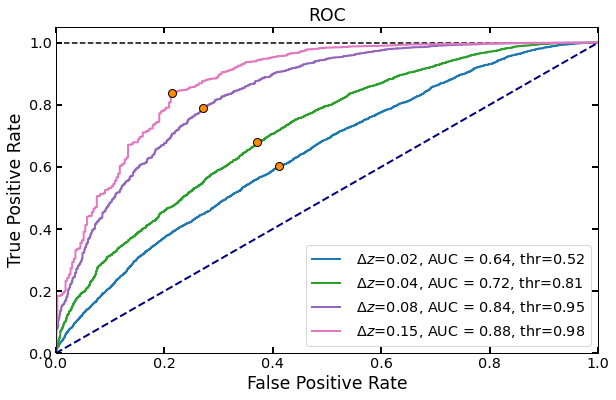

In [ ]:
files = [
 '/content/drive/MyDrive/GraphoVerse/NezNet/data/test_bs32_nt15000_lr0.001_nbr30_Dz0.02.npy',
 '/content/drive/MyDrive/GraphoVerse/NezNet/data/test_bs32_nt15000_lr0.001_nbr30_Dz0.04.npy',
 '/content/drive/MyDrive/GraphoVerse/NezNet/data/test_bs32_nt15000_lr0.001_nbr30_Dz0.08.npy',
 '/content/drive/MyDrive/GraphoVerse/NezNet/data/test_bs32_nt15000_lr0.001_nbr30_Dz0.15.npy']

size_te = 10000
plot_roc_dz(size_te, *files)

Best Threshold: 0.4971 with G-Mean: 0.8637
FPR: 0.1544, TPR: 0.8821
Best Threshold: 0.8441 with G-Mean: 0.8005
FPR: 0.2337, TPR: 0.8362
Best Threshold: 0.8994 with G-Mean: 0.7654
FPR: 0.2913, TPR: 0.8267
Best Threshold: 0.9466 with G-Mean: 0.7592
FPR: 0.271, TPR: 0.7907


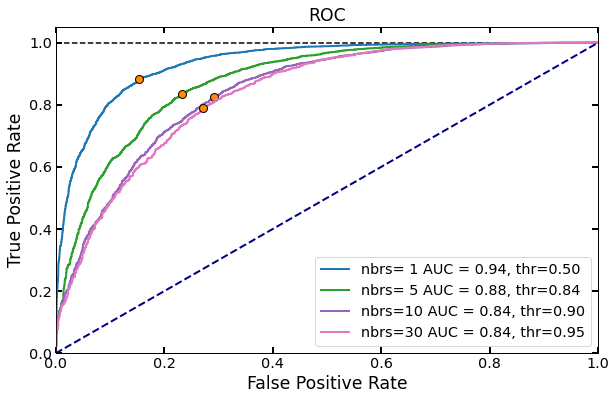

In [ ]:
files = [
 '/content/drive/MyDrive/GraphoVerse/NezNet/data/test_bs32_nt15000_lr0.001_nbr1_Dz0.08.npy',
 '/content/drive/MyDrive/GraphoVerse/NezNet/data/test_bs32_nt15000_lr0.001_nbr5_Dz0.08.npy',
 '/content/drive/MyDrive/GraphoVerse/NezNet/data/test_bs32_nt15000_lr0.001_nbr10_Dz0.08.npy',
 '/content/drive/MyDrive/GraphoVerse/NezNet/data/test_bs32_nt15000_lr0.001_nbr30_Dz0.08.npy']
size_te = 10000
plot_roc_nn(size_te,*files)

Best Threshold: 0.5235 with G-Mean: 0.5953
FPR: 0.4109, TPR: 0.6016
Best Threshold: 0.8057 with G-Mean: 0.6532
FPR: 0.3718, TPR: 0.6792
Best Threshold: 0.9466 with G-Mean: 0.7592
FPR: 0.271, TPR: 0.7907


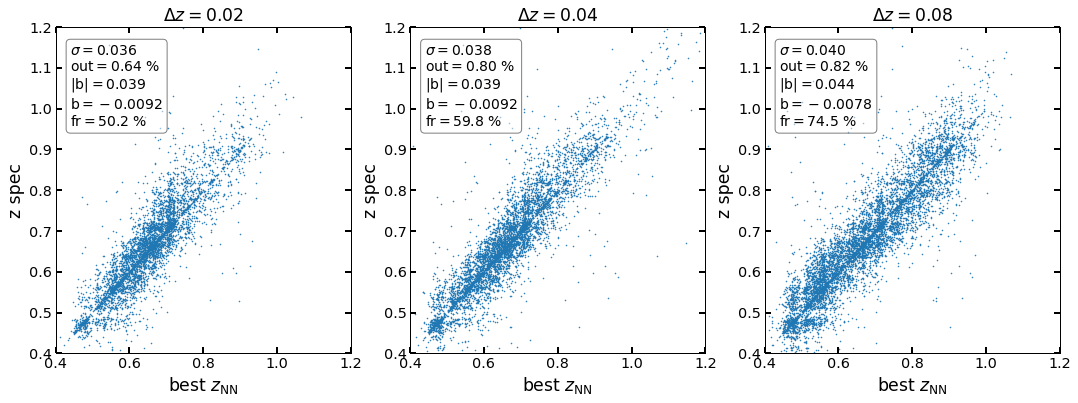

In [ ]:
files = [
 '/content/drive/MyDrive/GraphoVerse/NezNet/data/test_bs32_nt15000_lr0.001_nbr30_Dz0.02.npy',
 '/content/drive/MyDrive/GraphoVerse/NezNet/data/test_bs32_nt15000_lr0.001_nbr30_Dz0.04.npy',
 '/content/drive/MyDrive/GraphoVerse/NezNet/data/test_bs32_nt15000_lr0.001_nbr30_Dz0.08.npy',]
 #'/content/drive/MyDrive/GraphoVerse/NezNet/data/test_bs32_nt15000_lr0.001_nbr30_Dz0.15.npy']
plot_results_dz(size_te, *files)

Best Threshold: 0.4971 with G-Mean: 0.8637
FPR: 0.1544, TPR: 0.8821
Best Threshold: 0.8441 with G-Mean: 0.8005
FPR: 0.2337, TPR: 0.8362
Best Threshold: 0.8994 with G-Mean: 0.7654
FPR: 0.2913, TPR: 0.8267


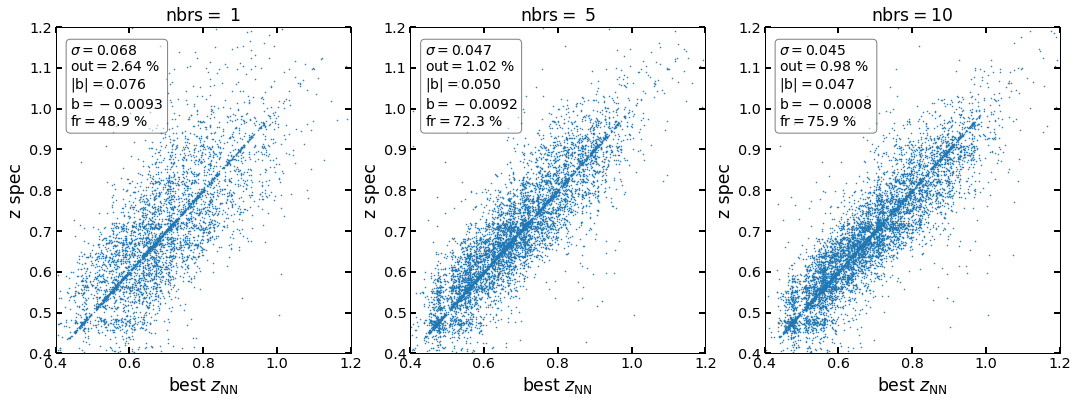

In [ ]:
files = [
 '/content/drive/MyDrive/GraphoVerse/NezNet/data/test_bs32_nt15000_lr0.001_nbr1_Dz0.08.npy',
 '/content/drive/MyDrive/GraphoVerse/NezNet/data/test_bs32_nt15000_lr0.001_nbr5_Dz0.08.npy',
 '/content/drive/MyDrive/GraphoVerse/NezNet/data/test_bs32_nt15000_lr0.001_nbr10_Dz0.08.npy']
 #'/content/drive/MyDrive/GraphoVerse/NezNet/data/test_bs32_nt15000_lr0.001_nbr30_Dz0.08.npy']

plot_results_nn(size_te,*files)

considering angular neighbours n_nbrs =  30
Dz to define a spectroscopic neighbour= 0.08


/content/drive/MyDrive/GraphoVerse/train.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.squeeze(np.array(test_results),axis=-1)


Best Threshold: 0.9466 with G-Mean: 0.7592
FPR: 0.271, TPR: 0.7907


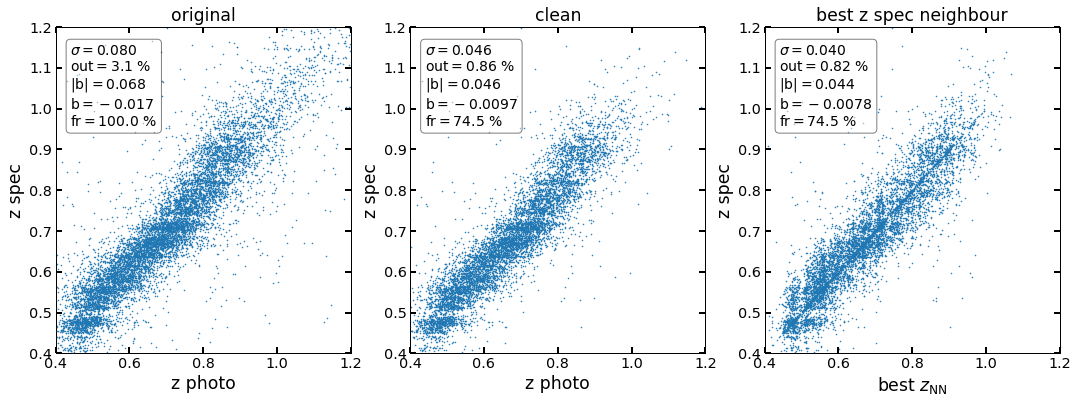

considering angular neighbours n_nbrs =  30
Dz to define a spectroscopic neighbour= 0.15


/content/drive/MyDrive/GraphoVerse/train.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.squeeze(np.array(test_results),axis=-1)


Best Threshold: 0.9828 with G-Mean: 0.8115
FPR: 0.2152, TPR: 0.839


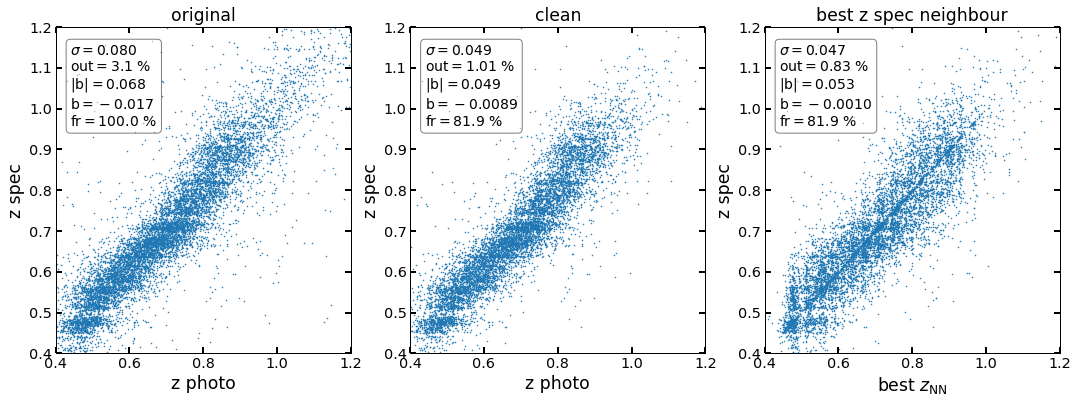

In [ ]:
list_to_plot = ['bs32_nt15000_lr0.001_nbr30_Dz0.08','bs32_nt15000_lr0.001_nbr30_Dz0.15']
size_te = 10000
for folderw in list_to_plot:
    modelout = NezNet(hidden_pre=32, hidden_cn=32, hidden_post=32, n_pre=1, n_post=1, act="relu", bn=False)
    #main(modelout, folderw, VIPERSGraphPhoto, size_te, do_metrics=True,)
    main(modelout, folderw, VIPERSGraphPhoto, size_te, do_metrics=False, do_colours=True, save=False)

considering angular neighbours n_nbrs =  30
Dz to define a spectroscopic neighbour= 0.08


/content/drive/MyDrive/GraphoVerse/train.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.squeeze(np.array(test_results),axis=-1)


Best Threshold: 0.9466 with G-Mean: 0.7592
FPR: 0.271, TPR: 0.7907
plot of color-color outliers


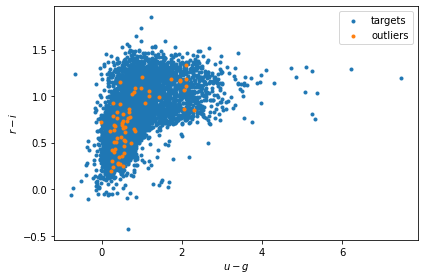

considering angular neighbours n_nbrs =  30
Dz to define a spectroscopic neighbour= 0.15


/content/drive/MyDrive/GraphoVerse/train.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.squeeze(np.array(test_results),axis=-1)


Best Threshold: 0.9828 with G-Mean: 0.8115
FPR: 0.2152, TPR: 0.839
plot of color-color outliers


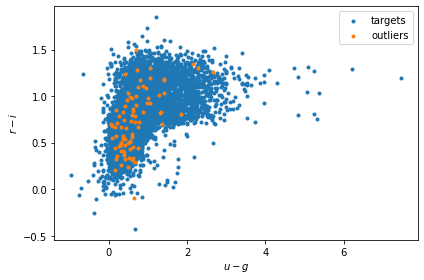

In [41]:
list_to_plot = ['bs32_nt15000_lr0.001_nbr30_Dz0.08','bs32_nt15000_lr0.001_nbr30_Dz0.15']
size_te = 10000
for folderw in list_to_plot:
    modelout = NezNet(hidden_pre=32, hidden_cn=32, hidden_post=32, n_pre=1, n_post=1, act="relu", bn=False)
    main(modelout, folderw, VIPERSGraphPhoto, size_te, do_metrics=False, do_colours=True, save=False)

Best Threshold: 0.9496 with G-Mean: 0.7408
fpr: 0.2697, tpr: 0.7514
fraction of clean data= 0.7042

graph results with optimal threshold 0.95:
fraction of clean data= 0.7042


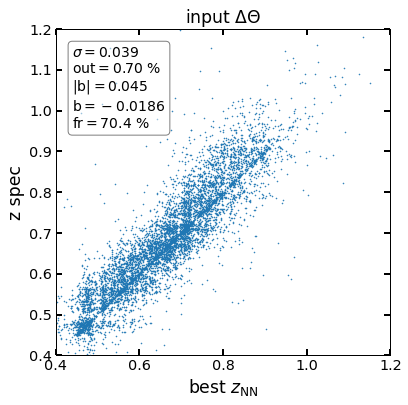

In [ ]:
size_te = 10000
files = '/content/drive/MyDrive/GraphoVerse/NezNet/data/test_hav_bs32_nt15000_lr0.001_nbr30_Dz0.08.npy'
 #'/content/drive/MyDrive/GraphoVerse/NezNet/data/test_dense_bs32_nt15000_lr0.001_nbr30_Dz0.08.npy',
 #'/content/drive/MyDrive/GraphoVerse/NezNet/data/test_bs32_nt15000_lr0.001_nbr30_Dz0.08.npy']
 #'/content/drive/MyDrive/GraphoVerse/NezNet/data/test_bs32_nt15000_lr0.001_nbr30_Dz0.08.npy',]
plot_results_single(size_te, files, title='input $\Delta \Theta$')

Best Threshold: 0.9496 with G-Mean: 0.7408
fpr: 0.2697, tpr: 0.7514
fraction of clean data= 0.7042

graph results with optimal threshold 0.95:
fraction of clean data= 0.7042
Best Threshold: 0.9444 with G-Mean: 0.7612
fpr: 0.2523, tpr: 0.7749
fraction of clean data= 0.7299

graph results with optimal threshold 0.94:
fraction of clean data= 0.7299


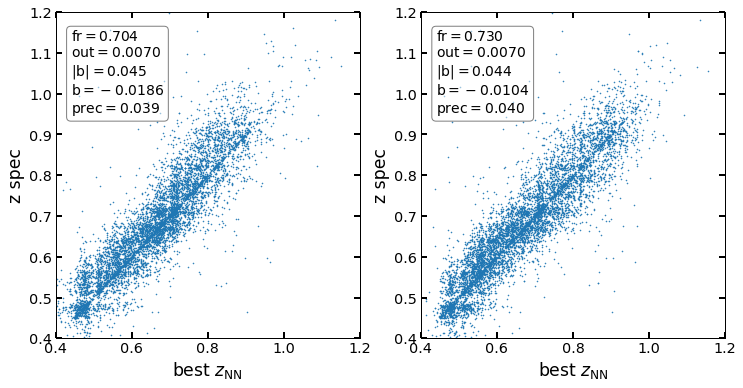

In [ ]:
size_te = 10000
files = ['/content/drive/MyDrive/GraphoVerse/NezNet/data/test_hav_bs32_nt15000_lr0.001_nbr30_Dz0.08.npy',
         '/content/drive/MyDrive/GraphoVerse/NezNet/data/test_radec_bs32_nt15000_lr0.001_nbr30_Dz0.08.npy']
 #'/content/drive/MyDrive/GraphoVerse/NezNet/data/test_dense_bs32_nt15000_lr0.001_nbr30_Dz0.08.npy',
 #'/content/drive/MyDrive/GraphoVerse/NezNet/data/test_bs32_nt15000_lr0.001_nbr30_Dz0.08.npy']
 #'/content/drive/MyDrive/GraphoVerse/NezNet/data/test_bs32_nt15000_lr0.001_nbr30_Dz0.08.npy',]
plot_results_compare(size_te, *files)

Best Threshold: 0.9323 with G-Mean: 0.7501
FPR: 0.3036, TPR: 0.8079


Best Threshold: 0.9466 with G-Mean: 0.7592
FPR: 0.271, TPR: 0.7907


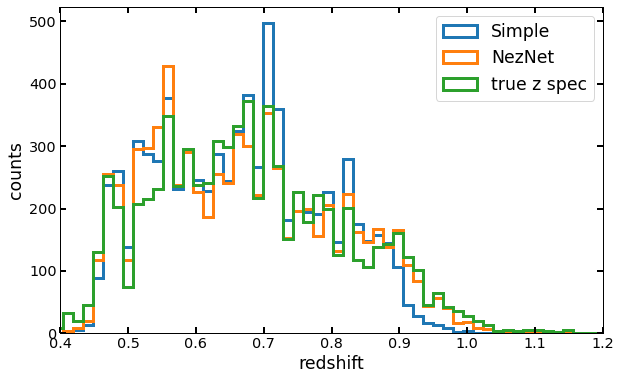

In [ ]:
files = [
 '/content/drive/MyDrive/GraphoVerse/NezNet/data/test_dense_bs32_nt15000_lr0.001_nbr30_Dz0.08.npy',
 '/content/drive/MyDrive/GraphoVerse/NezNet/data/test_bs32_nt15000_lr0.001_nbr30_Dz0.08.npy']
labels = ['Simple', 'NezNet']
PDFs(size_te, labels, *files)

# Gradients

In [ ]:
def compute_grad(modelout, weights, build_graph, size_te, size_grad, seed_te=881, folder = '/content/drive/MyDrive/GraphoVerse/NezNet/' ):
    global W4
    if not os.path.exists(folder + 'data/test_' + weights + '.npy'):
      print(folder + 'data/test_' + weights + '.npy')
      raise ValueError('test results for your model do not exist')

    # recover hyperparams
    string_nbrs , string_Dz = weights.split('_')[-2:]
    string_nbrs = string_nbrs.strip('nbr')
    string_Dz = string_Dz.strip('Dz')
    n_nbrs = int(string_nbrs)
    Dz = float(string_Dz)

    # create graph dataset
    z_min = 0.0
    z_max = 6.0
    nids = cat_max_id(W1,z_min,z_max)
    norms = VIP_norm(z_min,z_max) # norm [0,1]

    nids = cat_max_id(W4,z_min,z_max)
    rng = np.random.default_rng(seed_te)
    id_te = rng.choice(np.arange(nids), size=size_grad, replace=False)
    data_te = build_graph( id_te, *norms, n_nbrs=n_nbrs+1, transforms=NormalizeAdj(), z_min=z_min, z_max=z_max, Dz=Dz, filedata = W4)

    loader_te = DisjointLoader(data_te, shuffle=False)

    def convert_sparse_matrix_to_sparse_tensor(X):
        coo = X.tocoo()
        indices = np.mat([coo.row, coo.col]).transpose()
        return tf.SparseTensor(indices, coo.data, coo.shape)

    asp = convert_sparse_matrix_to_sparse_tensor(data_te[0].a)

    # load weights
    tf.keras.backend.clear_session()
    X = Input(shape=(data_te.n_node_features,))
    A = Input((None,), sparse=True)
    I = Input(shape=(), dtype=tf.int64)
    out   = modelout([X,A,I])
    model = Model(inputs=[X, A, I], outputs=out)
    model.load_weights(folder+weights+'/best_weights')

    # load results
    test_results = np.load(folder + 'data/test_' + weights + '.npy', allow_pickle=True)

    step = 0
    gradients = tf.zeros((2,data_te.n_node_features), dtype=tf.float32)  # pos examples
    for batch in loader_te:
      x = tf.cast(batch[0][0], dtype=tf.float32)  # input features 
      with tf.GradientTape() as tape:
        tape.watch(x)
        predictions = model([x,asp,batch[0][2]], training=False)
        _gradients = tf.math.abs(tape.gradient(predictions, x))   # with respect to input
        gradients = tf.concat([gradients,_gradients],axis=0)
      step += 1
      if step == loader_te.steps_per_epoch:
        break
    gradients = gradients[2:]
    gradients = tf.reshape(gradients,(step,2,data_te.n_node_features))

    # compute threshold
    nz = test_results[:,0].reshape(size_te,n_nbrs)
    tz = test_results[:,1].reshape(size_te,n_nbrs)
    sc = test_results[:,2].reshape(size_te,n_nbrs)
    lb = test_results[:,3].reshape(size_te,n_nbrs)

    # best NN
    amax = np.argmax(sc,-1)
    sc  = np.take_along_axis(sc,amax[:,None],axis=-1)
    tz  = np.take_along_axis(tz,amax[:,None],axis=-1)
    nz  = np.take_along_axis(nz,amax[:,None],axis=-1)
    lb  = np.take_along_axis(lb,amax[:,None],axis=-1)

    th = find_thres(lb, sc)[-1]

    gradients = tf.reshape(gradients,(size_grad,n_nbrs,2,data_te.n_node_features))
    gradients = tf.gather(gradients,amax[:size_grad],batch_dims=1)
    sc = np.squeeze(sc[:size_grad])
    gradients = gradients[sc>th]
    gradients = tf.math.reduce_mean(gradients,axis=0)

    np.save(folder + 'data/grad_' + weights, gradients)
    print('saving test results in ' + folder + 'data/grad_' + weights + '.npy')

    return

In [ ]:
size_grad = 1000
size_te = 10000
list_for_grads = [ 
 'bs32_nt15000_lr0.001_nbr30_Dz0.08',
 'bs32_nt15000_lr0.001_nbr30_Dz0.02',
 'bs32_nt15000_lr0.001_nbr30_Dz0.04',
 'hav_bs32_nt15000_lr0.001_nbr30_Dz0.08',
 'dense_bs32_nt15000_lr0.001_nbr30_Dz0.08'
 ]

for folderw in list_for_grads:
  if folderw.startswith('bs') or folderw.startswith('neznet'):
    modelout = NezNet(hidden_pre=32, hidden_cn=32, hidden_post=32, n_pre=1, n_post=1, act="relu", bn=False)
    compute_grad(modelout, folderw, VIPERSGraphPhoto, size_te, size_grad)

  elif folderw.startswith('hav'):
    modelout = NezNet(hidden_pre=32, hidden_cn=32, hidden_post=32, n_pre=1, n_post=1, act="relu", bn=False)
    compute_grad(modelout, folderw, VIPERSGraphHav, size_te, size_grad)

  elif folderw.startswith('radec'):
    modelout = NezNet(hidden_pre=32, hidden_cn=32, hidden_post=32, n_pre=1, n_post=1, act="relu", bn=False)
    compute_grad(modelout, folderw, VIPERSGraph, size_te, size_grad)

  elif folderw.startswith('dense'):
    modelout = DenseNet(hidden_pre=32, hidden_post=32, n_pre=2, n_post=1, act="relu", bn=False)
    compute_grad(modelout, folderw, VIPERSGraphPhoto, size_te, size_grad)

  else:
    pass

Best Threshold: 0.9323 with G-Mean: 0.7501
FPR: 0.3036, TPR: 0.8079
saving test results in /content/drive/MyDrive/GraphoVerse/NezNet/data/grad_dense_bs32_nt15000_lr0.001_nbr30_Dz0.08.npy


(2, 8)


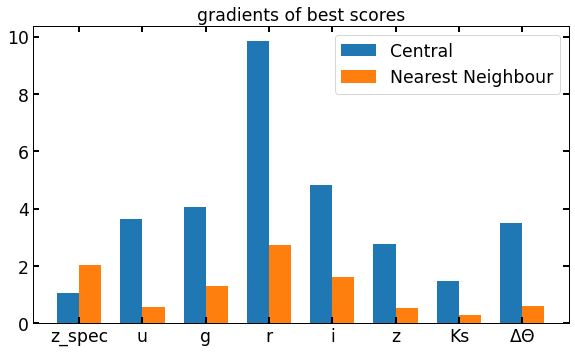

In [ ]:
plot_pair_gradients('hav_bs32_nt15000_lr0.001_nbr30_Dz0.08')

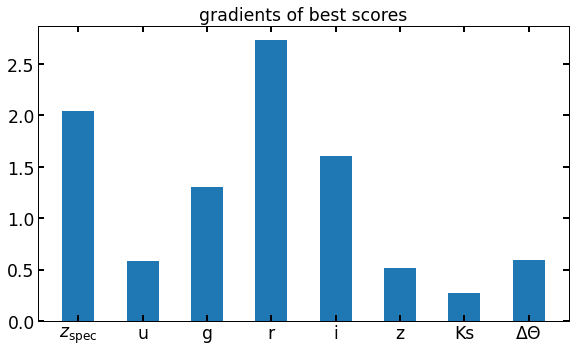

In [ ]:
plot_neigh_gradients('hav_bs32_nt15000_lr0.001_nbr30_Dz0.08')

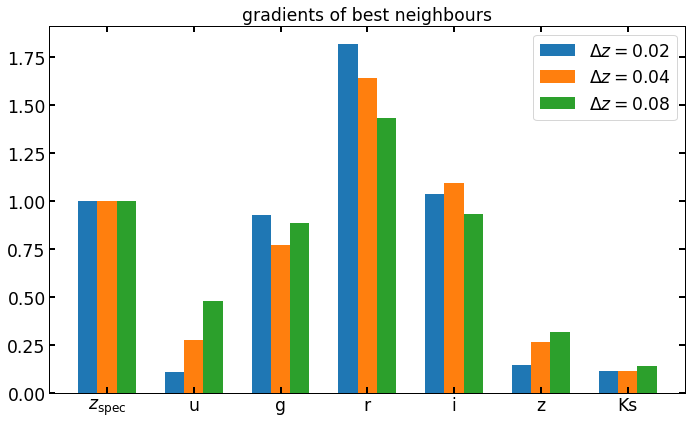

In [ ]:
list_for_grads = [ 
 'bs32_nt15000_lr0.001_nbr30_Dz0.02',
 'bs32_nt15000_lr0.001_nbr30_Dz0.04',
 'bs32_nt15000_lr0.001_nbr30_Dz0.08']
plot_Dz_gradients(*list_for_grads)